<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_CVP_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Setup and Load Data**

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

#mount drive
from google.colab import drive
drive.mount('/content/drive')

#dataset path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v1i.folder'

print(f"\nDataset path: {BASE_PATH}")

TensorFlow Version: 2.19.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Dataset path: /content/drive/MyDrive/Colab Notebooks/TransitLK_MSFCD_CVM.v1i.folder


##**Exploratory Data Analysis**

Exploratory Data Analysis

Dataset structure found:
  train: Crash=372, Normal=107, Total=479
  test: Crash=53, Normal=16, Total=69
  valid: Crash=107, Normal=30, Total=137

Dataset loaded: 685 images
   split  label                                           filename
0  train  crash  frame_0304_jpg.rf.e927a51cf337c5865482500ec768...
1  train  crash  frame_0657_jpg.rf.359712541d7a62a96cefd93b32f7...
2  train  crash  frame_0857_jpg.rf.5375b252c55f729e0b18b4d525a8...
3  train  crash  frame_0807_jpg.rf.0c66083928632501b428f1573880...
4  train  crash  frame_0585_jpg.rf.1695995818d0ff6815f4d35ea091...

1. Class Distribution (Crash vs Normal):
label
crash     532
normal    153
Name: count, dtype: int64

Crash rate: 77.66%


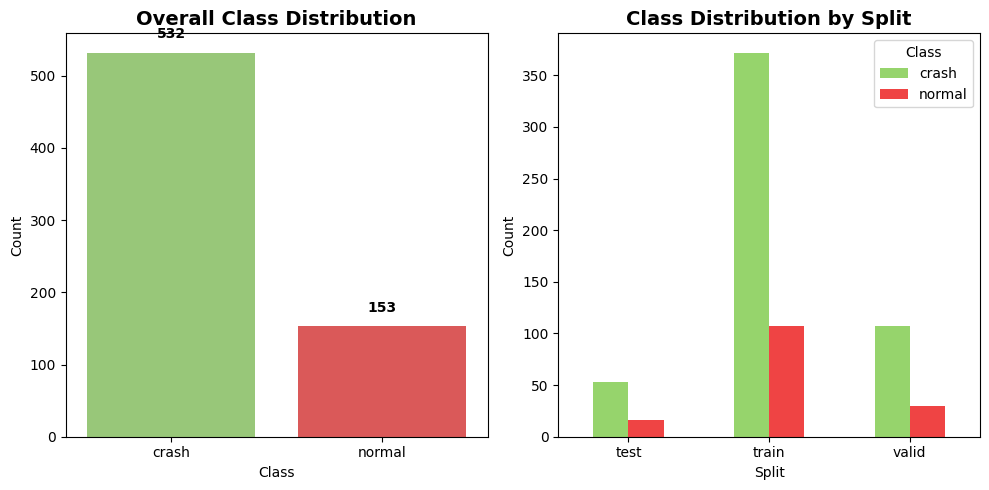


2. Sample Images:


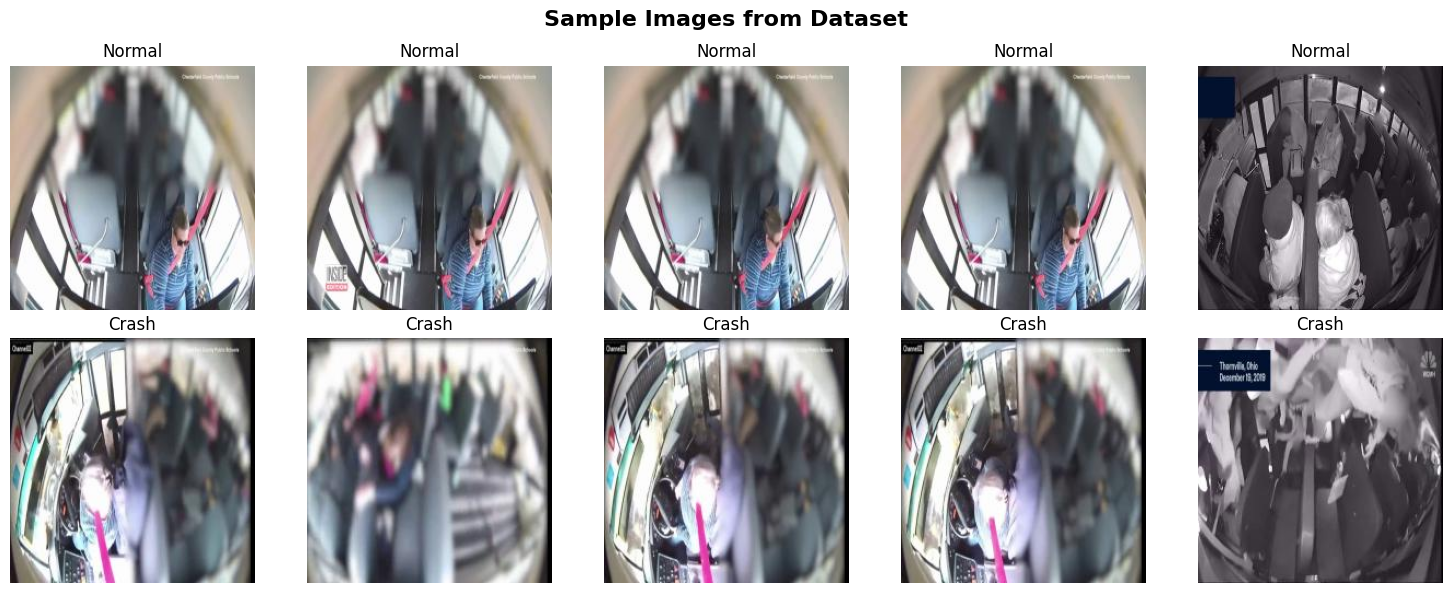

In [2]:
print("Exploratory Data Analysis\n")

#check if path exists and list structure
import os
if os.path.exists(BASE_PATH):
    print("Dataset structure found:")
    for split in ['train', 'test', 'valid']:
        split_path = os.path.join(BASE_PATH, split)
        if os.path.exists(split_path):
            crash_dir = os.path.join(split_path, 'crash')
            normal_dir = os.path.join(split_path, 'normal')
            crash_count = len([f for f in os.listdir(crash_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(crash_dir) else 0
            normal_count = len([f for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]) if os.path.exists(normal_dir) else 0
            print(f"  {split}: Crash={crash_count}, Normal={normal_count}, Total={crash_count + normal_count}")
else:
    print("Path not found! Please check your dataset location.")

#create dataframe for analysis
data = []
for split in ['train', 'test', 'valid']:
    for label in ['crash', 'normal']:
        folder = os.path.join(BASE_PATH, split, label)
        if os.path.exists(folder):
            files = [f for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:
                data.append({'split': split, 'label': label, 'filename': f})

df = pd.DataFrame(data)
print(f"\nDataset loaded: {len(df)} images")
print(df.head())

#class distribution analysis
print("\n1. Class Distribution (Crash vs Normal):")
class_counts = df['label'].value_counts()
print(class_counts)
print(f"\nCrash rate: {class_counts.get('crash', 0)/len(df):.2%}")

#visualize class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=class_counts.index, y=class_counts.values, palette=['#96d46c','#ef4444'])
plt.title('Overall Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 20, str(v), ha='center', fontweight='bold')

#distribution by split
plt.subplot(1, 2, 2)
split_counts = df.groupby(['split', 'label']).size().unstack(fill_value=0)
split_counts.plot(kind='bar', ax=plt.gca(), color=['#96d46c', '#ef4444'])
plt.title('Class Distribution by Split', fontsize=14, fontweight='bold')
plt.xlabel('Split')
plt.ylabel('Count')
plt.legend(title='Class')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#show sample images
print("\n2. Sample Images:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')

for idx, label in enumerate(['normal', 'crash']):
    label_df = df[df['label'] == label]
    if len(label_df) > 0:
        sample_files = label_df.sample(min(5, len(label_df)))['filename'].values
        for i, filename in enumerate(sample_files):
            #get full path (assuming from train split for samples)
            img_path = os.path.join(BASE_PATH, 'train', label, filename)
            if not os.path.exists(img_path):
                #try other splits if not in train
                for split in ['valid', 'test']:
                    img_path = os.path.join(BASE_PATH, split, label, filename)
                    if os.path.exists(img_path):
                        break

            if os.path.exists(img_path):
                img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
                axes[idx, i].imshow(img)
                axes[idx, i].set_title(f'{label.capitalize()}')
                axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

##**Data Preprocessing and Configuration**

In [3]:
print("Data Preprocessing & Configuration")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

#parameters
params = {
    'target_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'class_mode': 'binary',
    'seed': 42
}

print(f"\nImage Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

#check class distribution in training set specifically
train_crash = len(os.listdir(os.path.join(BASE_PATH, 'train', 'crash')))
train_normal = len(os.listdir(os.path.join(BASE_PATH, 'train', 'normal')))
print(f"\nTraining set - Crash: {train_crash}, Normal: {train_normal}")

if train_crash > 0 and train_normal > 0:
    imbalance_ratio = train_normal / train_crash
    print(f"Imbalance Ratio (Normal:Crash): {imbalance_ratio:.2f}:1")

    if imbalance_ratio > 1.5:
        print("Dataset is imbalanced. Will use class weights.")
        use_class_weights = True
    else:
        use_class_weights = False
else:
    use_class_weights = False

Data Preprocessing & Configuration

Image Size: (224, 224)
Batch Size: 32

Training set - Crash: 372, Normal: 107
Imbalance Ratio (Normal:Crash): 0.29:1


##**Handle CLass Imbalance**

In [5]:
print("Handling Class Imbalance")

if use_class_weights:
    #calculate class weights (inverse the frequency)
    total = train_crash + train_normal
    weight_for_crash = (1 / train_crash) * (total / 2.0)
    weight_for_normal = (1 / train_normal) * (total / 2.0)

    class_weights = {0: weight_for_normal, 1: weight_for_crash}
    print(f"Class Weights: {class_weights}")
else:
    class_weights = None
    print("No class weights needed (balanced dataset)")

Handling Class Imbalance
No class weights needed (balanced dataset)


##**Data Generation**

In [6]:
print("Creating Data Generators")

#training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

#validation/test data - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

#create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    **params,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    **params,
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    **params,
    shuffle=False
)

print(f"\nTraining samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

#verify class indices
print(f"\nClass indices: {train_generator.class_indices}")

Creating Data Generators
Found 479 images belonging to 2 classes.
Found 137 images belonging to 2 classes.
Found 69 images belonging to 2 classes.

Training samples: 479
Validation samples: 137
Test samples: 69

Class indices: {'crash': 0, 'normal': 1}


##**Building Model Using Transfer Learning**

In [7]:
print("Building Model")

def build_model():
    #MobileNetV2 is lightweight and good for edge deployment as we are using phone as a central
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        alpha=1.0
    )

    #freeze base model initially (similar to training on features first)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)  #binary classification

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model()

#compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

#model architecture
print("\nModel Architecture:")
model.summary()

Building Model
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,713 (9.26 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

#**Model Training**

In [10]:
print("Model Training")

callbacks_phase1 = [
    EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_phase1.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=20,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

print("Feature Extraction Complete!")

Model Training
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# ====================================================
# 8. FINE-TUNING (Unfreeze Top Layers)
# ====================================================
print("Phase 2: Fine-tuning Model")

# Unfreeze top 30 layers (similar to tuning XGBoost hyperparameters)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 10x lower for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(f"Trainable variables: {len(model.trainable_variables)}")

callbacks_phase2 = [
    EarlyStopping(
        monitor='val_auc',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        'crash_model_final.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-8,
        verbose=1
    )
]

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

print("Training Complete!")

In [ ]:
# ====================================================
# 9. MODEL EVALUATION (Same as XGBoost notebook)
# ====================================================
print("Model Evaluation")

# Load best model
model = tf.keras.models.load_model('crash_model_final.h5')

# Get predictions on test set
test_generator.reset()
y_pred_prob = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Get true labels
y_true = test_generator.classes[:len(y_pred)]  # Match lengths

print(f"\nTest samples evaluated: {len(y_true)}")

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.2%}")

# Classification Report
print("\nClassification Report:")
target_names = ['Crash', 'Normal'] if test_generator.class_indices['crash'] == 0 else ['Normal', 'Crash']
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:len(y_true)])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# ====================================================
# 10. TRAINING HISTORY VISUALIZATION
# ====================================================
def plot_training(history1, history2):
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    auc = history1.history['auc'] + history2.history['auc']
    val_auc = history1.history['val_auc'] + history2.history['val_auc']

    epochs = range(1, len(acc) + 1)
    phase1_epochs = len(history1.history['accuracy'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy
    axes[0].plot(epochs, acc, 'b-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    axes[0].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss
    axes[1].plot(epochs, loss, 'b-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r-', label='Validation Loss')
    axes[1].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # AUC
    axes[2].plot(epochs, auc, 'b-', label='Training AUC')
    axes[2].plot(epochs, val_auc, 'r-', label='Validation AUC')
    axes[2].axvline(phase1_epochs, color='g', linestyle='--', alpha=0.5, label='Fine-tuning start')
    axes[2].set_title('Model AUC', fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('AUC')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history1, history2)

In [ ]:
# ====================================================
# 11. INFERENCE FUNCTION (For Future Use)
# ====================================================
def predict_crash(image_path, model, threshold=0.5):
    """
    Predict crash probability for a single image
    Returns: dict with probability and class
    """
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = tf.expand_dims(img_array, 0)

    prob = model.predict(img_array, verbose=0)[0][0]

    # Determine class based on class_indices
    # If crash is class 0, then prob < 0.5 is crash, else normal
    # If crash is class 1, then prob > 0.5 is crash
    is_crash = prob > threshold if test_generator.class_indices['crash'] == 1 else prob < threshold

    return {
        'crash_probability': float(prob),
        'is_crash': bool(is_crash),
        'predicted_class': 'crash' if is_crash else 'normal'
    }

# Test on a sample image
test_img_path = os.path.join(BASE_PATH, 'test', 'crash', os.listdir(os.path.join(BASE_PATH, 'test', 'crash'))[0])
result = predict_crash(test_img_path, model)
print(f"\nSample Prediction:")
print(f"Image: {test_img_path}")
print(f"Result: {result}")

In [ ]:
# ====================================================
# 12. EXPORT MODEL (TFLite for Edge Deployment)
# ====================================================
print("Exporting Model for Deployment")

# Save Keras model
model.save('crash_detection_cv_model.h5')
print("✓ Saved as crash_detection_cv_model.h5")

# Convert to TFLite (for mobile/edge deployment)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('crash_detection_cv_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("✓ Saved as crash_detection_cv_model.tflite")

# Download files
files.download('crash_detection_cv_model.h5')
files.download('crash_detection_cv_model.tflite')